# Database : MIT-BIH ST Change Database

300 ~ 322 ECG Recording : ST Depression  

323 ~ 327 ECG Recording : ST Elevation

In [153]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

import umap

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

In [3]:
# Data Extract From Physionet *.dat

input_path = "../ECG_DATASET/mitbih_stch/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
#     if l in ["00735","03665"]:
#         continue
    records_list.append(l)
records.close()
print(records_list)

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327']


In [4]:
#record = wfdb.rdsamp("./ECG_DATASET/mitbih_atrial/files/00735", sampfrom=0, sampto=650000)
#annotation =wfdb.rdann("./ECG_DATASET/mitbih_atrial/files/00735","atr", sampfrom=0, sampto=650000)
idx = -4
record = wfdb.rdrecord("../ECG_DATASET/mitbih_stch/"+records_list[idx])
annotation =wfdb.rdann("../ECG_DATASET/mitbih_stch/"+records_list[idx],"atr")

In [5]:
record.__dict__

{'record_name': '324',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 649224,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG', 'ECG'],
 'p_signal': array([[ 0.31      ,  0.41333333],
        [ 0.32      ,  0.40666667],
        [ 0.33333333,  0.41333333],
        ...,
        [-0.11333333, -0.25333333],
        [-0.12666667, -0.26      ],
        [-0.11333333, -0.25333333]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['324.dat', '324.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [300.0, 300.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [93, 124],
 'checksum': [28745, 25491],
 'block_size': [0, 0]}

In [6]:
def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], sampfrom=sampfrom, sampto = sampto)
    record_ann = wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto) # R Peak x_position
    record_ann_sym = wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto) # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)

    return record_sig, record_ann, record_ann_sym

In [7]:
# idx = 
sampfrom = 0
sampto = record.__dict__["sig_len"]
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx,sampfrom,sampto)
print(record_sig)
# print(record_ann)

(array([[ 0.31      ,  0.41333333],
       [ 0.32      ,  0.40666667],
       [ 0.33333333,  0.41333333],
       ...,
       [-0.11333333, -0.25333333],
       [-0.12666667, -0.26      ],
       [-0.11333333, -0.25333333]]), {'fs': 360, 'sig_len': 649224, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['ECG', 'ECG'], 'comments': []})


<IPython.core.display.Javascript object>


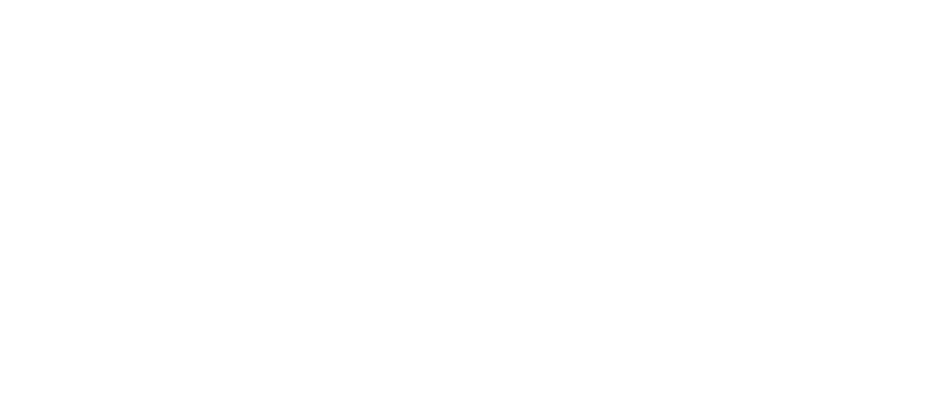

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,4))
ax_ann = fig.add_subplot(1,1,1)
ax_ann.set_title("Subject {}".format(records_list[idx]))

re_signal = np.array(record_sig[0])
ch0,ch1 = np.array_split(re_signal,2,axis=1)

x_data = ch0
ax_ann.plot(x_data,color="green")

ann_sample = record_ann.__dict__["sample"]
ann_sym = record_ann.__dict__["symbol"]

for i,x_location in enumerate(ann_sample):
    ax_ann.annotate(ann_sym[i], xy=(x_location,x_data[x_location-sampfrom]),
                    xycoords="data", textcoords="offset pixels", xytext=(3,17))

record_ann_x = [x_location-sampfrom-1 for i,x_location in enumerate(ann_sample)]
record_ann_v = [x_data[x_location-sampfrom-1] for x_location in record_ann_x]
ax_ann.plot(record_ann_x, record_ann_v, "ro", linewidth=2, fillstyle="none")

fig.show()

In [9]:
import numpy as np
from scipy import signal
from pandas import Series
import padasip as pa

In [10]:
# x_data : data
# f = pa.filters.FilterNLMS(n=4,mu=0.1,w="random")
# d = 
# y,e,w = f.run(x_data,)

def BandpassECG(Fs,data):
    w1 = 0.5*2/Fs # 5hz cut-off (High-pass) and normalize / Nyquist Frequency : (2/Fs)
    w2 = 15*2/Fs # 15hz cut-off (low-pass) and normalize
    b, a = signal.butter(4, [w1,w2], "bandpass") # 5~15Hz를 Filtering하는 Butterworth filter
    
    ECG_BP = signal.filtfilt(b,a,data)
    
    return ECG_BP

fs = 360
x_data = x_data.reshape(-1)
ECG_BP = BandpassECG(fs,x_data)

<IPython.core.display.Javascript object>


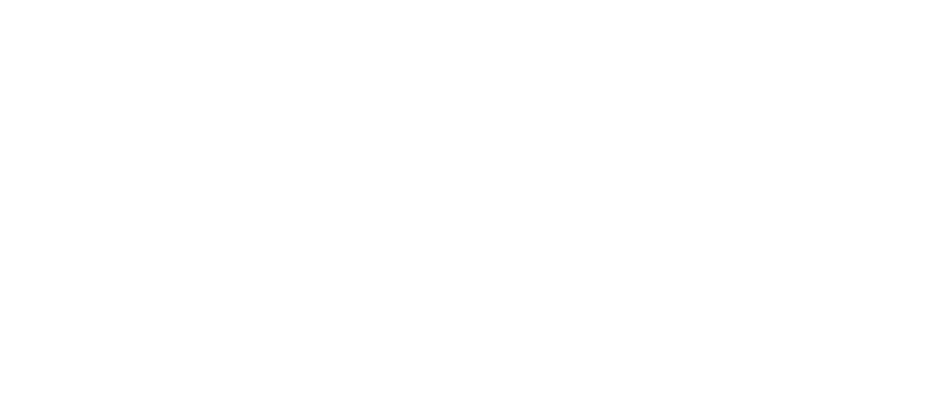

In [11]:
fig = plt.figure(figsize=(9.5,4))

ecg_r = fig.add_subplot(111)
ecg_r.set_title("Subject : {}, Lead : ".format(records_list[idx])+record_sig[1]["sig_name"][0])
# ecg_r.plot(x_data,color="blue")
ecg_r.plot(ECG_BP,color="red")
# ecg_r.plot(rpeaks,rpeaks_y,"ro", linewidth=2, fillstyle="none")
ecg_r.grid(True,"both")

In [12]:
# R peak Detection?

def BandpassECG(Fs,data):
    w1 = 0.5*2/Fs # 5hz cut-off (High-pass) and normalize / Nyquist Frequency : (2/Fs)
    w2 = 15*2/Fs # 15hz cut-off (low-pass) and normalize
    b, a = signal.butter(4, [w1,w2], "bandpass") # 5~15Hz를 Filtering하는 Butterworth filter
    
    ECG_BP = signal.filtfilt(b,a,data)
    
    return ECG_BP

def Differentiate(ecg):
    ecg_df = np.diff(ecg)
    ecg_sq = np.power(ecg_df,2)
    return np.insert(ecg_sq, 0, ecg_sq[0])

def movingAverage(ecg, N=20):
    window = np.ones((1,N)) / N
    ecg_ma = np.convolve(np.squeeze(ecg), np.squeeze(window))
    ecg_ma2 = np.convolve(np.squeeze(ecg_ma), np.squeeze(window))
    return ecg_ma2

def QRSPeaks(ecg, raw, Fs):
    """
    1. smooth한 데이터 값을 기준으로 Peak를 탐지함
    2. Smooth Peak를 기반으로 원 데이터의 final peak를 다시 탐지
    """
    peaks, _ = signal.find_peaks(ecg, height=np.mean(ecg), distance=round(Fs*0.2))
    
    final_peaks = []
    for pi in peaks:
        # pi : smooth peak
        start = pi - round(Fs/20)
        end = pi
        segment = raw[start:end]
        ei = signal.find_peaks(segment, height=np.mean(segment), distance=round(Fs*0.2))
        final_peaks.append(ei)
#         final_peaks.append(ei+pi-round(Fs/20)-1)
    print(final_peaks)
    return peaks

In [13]:
import numpy as np
from scipy.signal import butter,lfilter, freqz
from scipy.signal import medfilt
def fix_baseline_wander(data, fs=360): #two median Filter
    data = np.array(data)
    winsize = int(round(0.2*fs))
    
    if winsize%2==0:
        winsize+=1
    
    baseline_estimate = medfilt(data, kernel_size=winsize)
    winsize = int(round(0.4*fs))
    
    if winsize%2==0:
        winsize+=1
        
    baseline_estimate = medfilt(baseline_estimate, kernel_size=winsize)
    ecg_blr = data - baseline_estimate
    return np.array(ecg_blr), baseline_estimate.tolist()

In [14]:
ecg_blr, baseline = fix_baseline_wander(x_data,360)

<IPython.core.display.Javascript object>


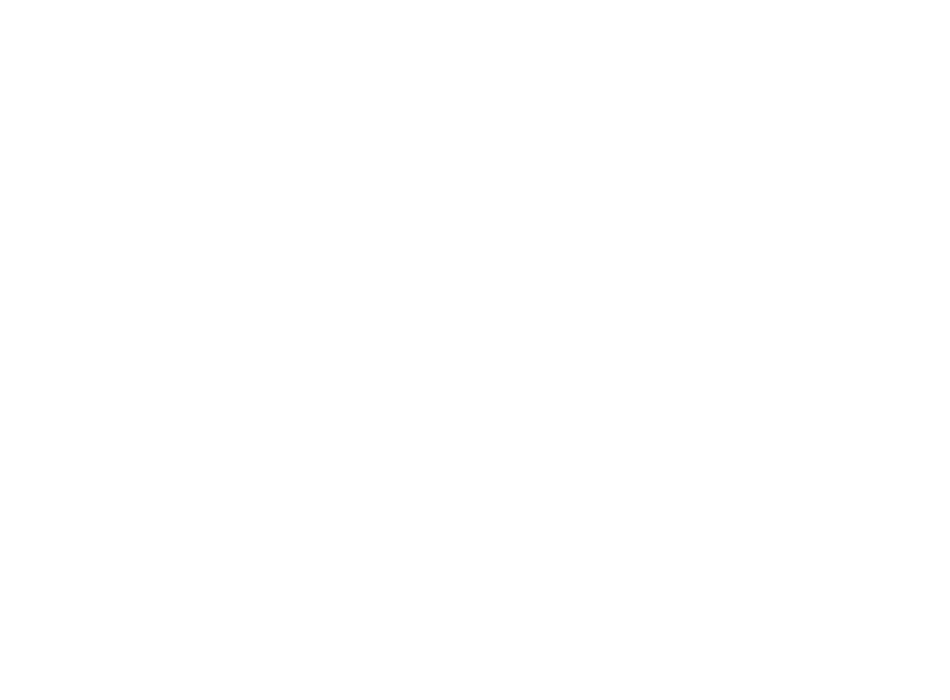

In [15]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,7))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(x_data,"-b", label="Raw Signal")
ax1.plot(baseline,"r-", label="Raw Signal")
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
ax2.set_title("Remove BaseLine")
ax2.plot(ecg_blr, "b-", label="Raw Signal - baseline")
ax2.legend()

plt.show()

In [16]:
from skimage.restoration import denoise_wavelet
def Denoise_wavelet_skimage(data, method, wavelet):
    x_denoise = denoise_wavelet(data, method=method, mode="soft",wavelet_levels=15, wavelet=wavelet, rescale_sigma="True")
    return x_denoise

In [17]:
def Denoise_wavelet_Pywt(data):
    import pywt
    w = pywt.Wavelet("sym8")
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    print("Max-level", maxlev)
    threshold = 0.04
    coeffs = pywt.wavedec(data, "sym8", level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
    datas = pywt.waverec(coeffs, "sym8")
    return datas

In [18]:
# datarec = Denoise_wavelet_Pywt(ecg_blr)
datarec = Denoise_wavelet_skimage(ecg_blr, "BayesShrink", "sym8")

<IPython.core.display.Javascript object>


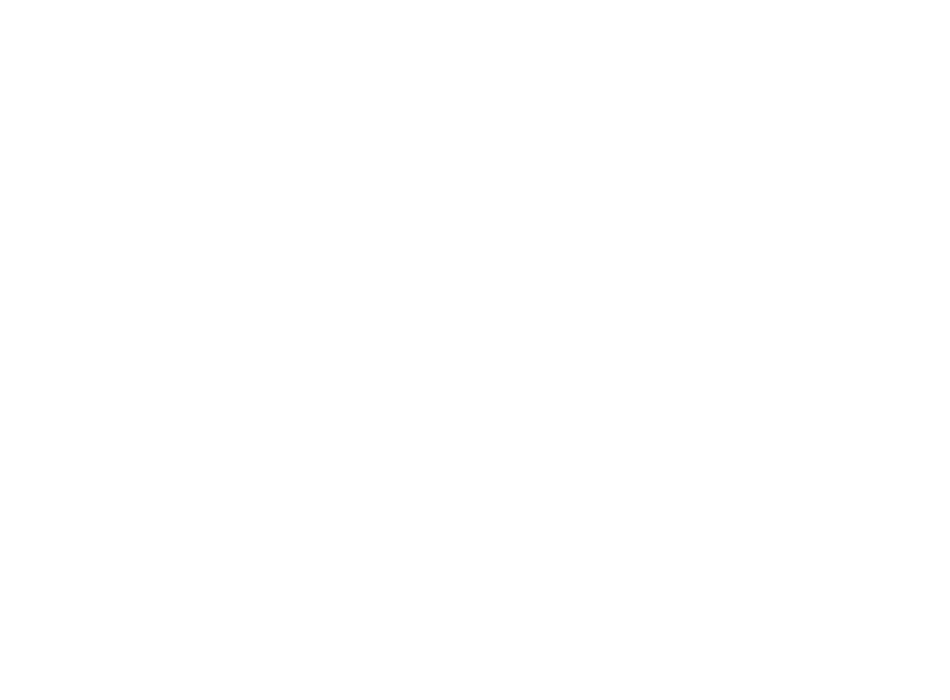

In [19]:
fig = plt.figure(figsize=(9.5,7))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(x_data,"-b", label="Raw signal")
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
ax2.set_title("Wavelet Denoising")
ax2.plot(datarec, "b-", label="Denoising")
ax2.legend()

plt.tight_layout()
plt.show()

> Reference : A Simple and Robustness Algorithm for ECG R- peak Detection

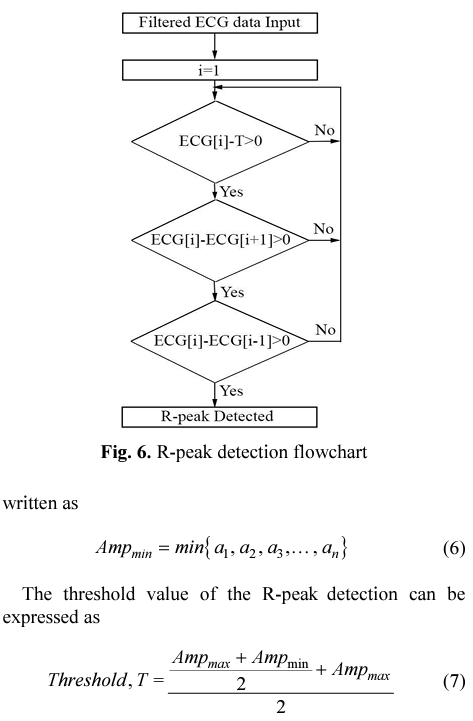

In [20]:
def calc_Threshold(data_amp):
    amp_max = np.max(data_amp)
    amp_min = np.min(data_amp)
    t = (((amp_max+amp_min)/2) + amp_max) / 2
    return t

threshold = calc_Threshold(datarec)
print(threshold)

0.867761229658884


In [21]:
def peaks_detection(data,threshold):
    data_len = len(data)
    r_peaks = []
    for i,amp in enumerate(data):
        if i == 0 or i == data_len-1:
            continue
        if data[i]-threshold > 0:
            if data[i]-data[i+1] > 0:
                if data[i]-data[i-1] > 0:
                    r_peaks.append(i)
    print(len(r_peaks), len(ann_sample))
    return r_peaks

r_peaks = peaks_detection(datarec,threshold)

1734 1740


<IPython.core.display.Javascript object>


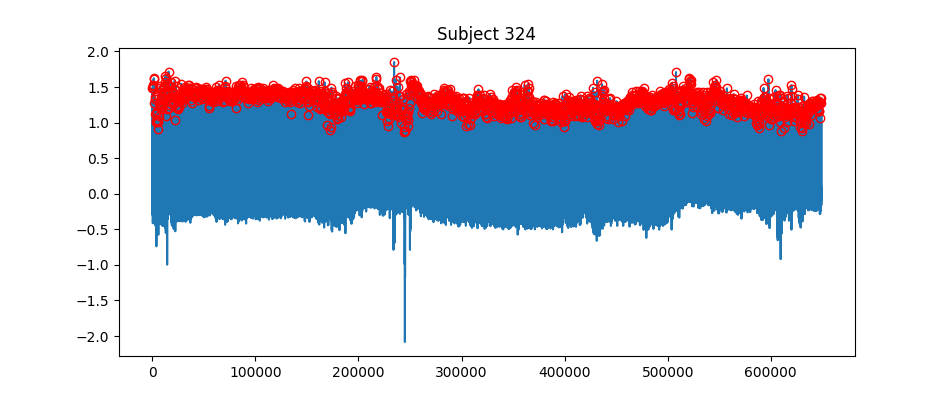

In [22]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,4))
detect_p = fig.add_subplot(1,1,1)
detect_p.set_title("Subject {}".format(records_list[idx]))

detect_p.plot(datarec)

peak_amp = [datarec[r] for r in r_peaks]
detect_p.plot(r_peaks, peak_amp, "ro", linewidth=2, fillstyle="none")

fig.show()

In [80]:
# biosppy use
from biosppy import signals
rpeaks = ecg.engzee_segmenter(signal=datarec,sampling_rate=360,threshold=0.63)
len(rpeaks[0])

1738

<IPython.core.display.Javascript object>


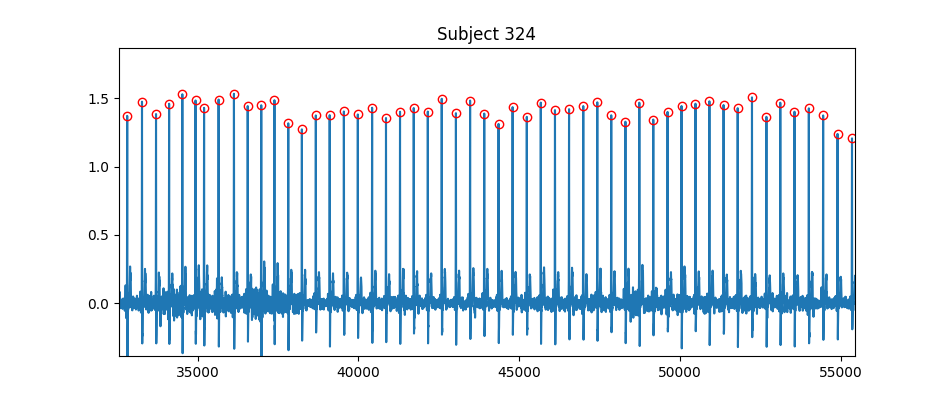

In [42]:
%matplotlib notebook
fig = plt.figure(figsize=(9.5,4))
detect_p = fig.add_subplot(1,1,1)
detect_p.set_title("Subject {}".format(records_list[idx]))

detect_p.plot(datarec)

peak_amp = [datarec[r] for r in rpeaks]
detect_p.plot(rpeaks, peak_amp, "ro", linewidth=2, fillstyle="none")

fig.show()

In [81]:
heartbeat = ecg.extract_heartbeats(signal=np.array(datarec), rpeaks=rpeaks[0], sampling_rate=360, before=0.4, after=0.4)

In [97]:
heartbeats = heartbeat[0]
len(heartbeats[0])

288

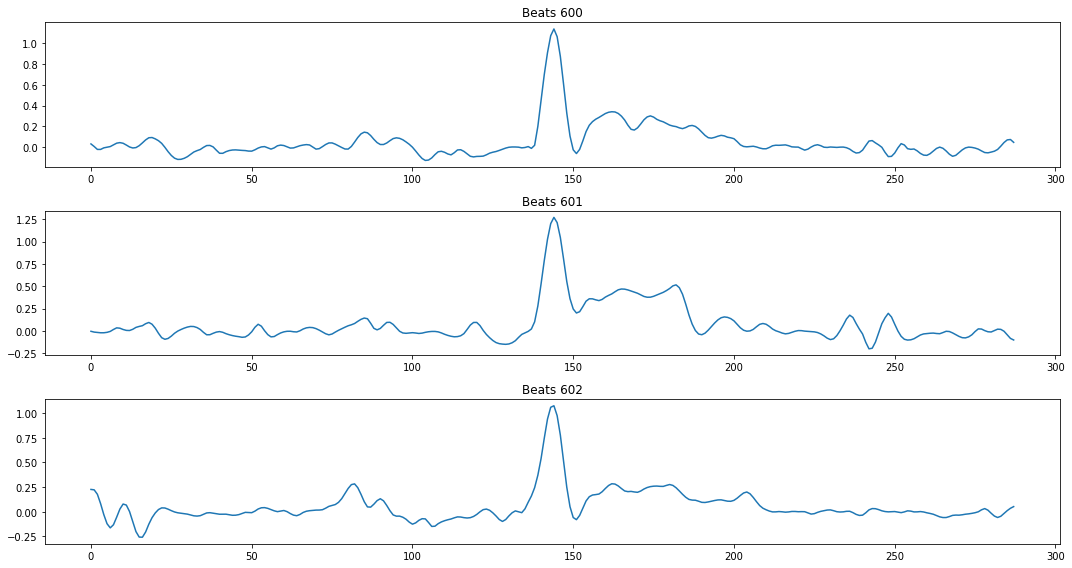

In [94]:
%matplotlib inline
idx = 600
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(3,1,1)
ax1.set_title("Beats {}".format(idx))
ax1.plot(heartbeats[idx])

ax2 = fig.add_subplot(3,1,2)
ax2.set_title("Beats {}".format(idx+1))
ax2.plot(heartbeats[idx+1])

ax3 = fig.add_subplot(3,1,3)
ax3.set_title("Beats {}".format(idx+2))
ax3.plot(heartbeats[idx+2])

fig.tight_layout()
fig.show()

### 1D Signal Clustering

Methods

1. Embedding
2. Clustering

Data Len : 288

Previous Literature : K-means, test

In [221]:
from sklearn.preprocessing import MinMaxScaler

# Frist, Scaling each Data

scaler = MinMaxScaler()
data_scale = scaler.fit_transform(heartbeats)

In [222]:
data_scale

array([[0.47460689, 0.39139023, 0.37246125, ..., 0.6724598 , 0.70766714,
        0.66149116],
       [0.52586596, 0.39357933, 0.33660722, ..., 0.67414859, 0.707816  ,
        0.65928144],
       [0.63557834, 0.51289789, 0.44550481, ..., 0.68225773, 0.72008846,
        0.67191273],
       ...,
       [0.60586275, 0.47286345, 0.40370921, ..., 0.67665915, 0.71557263,
        0.66823503],
       [0.5052603 , 0.38079496, 0.33521505, ..., 0.67363426, 0.70954677,
        0.66327404],
       [0.48892568, 0.39031697, 0.36030362, ..., 0.63937029, 0.66190459,
        0.61327713]])

In [266]:
from sklearn.cluster import KMeans

k = 2

model = KMeans(n_clusters = k, random_state = 100)

model.fit(heartbeats)

cluster_result = model.fit_predict(heartbeats)


def kmeans_Cluster(beat_data, k, random_state):
    model = kMeans(n_clusters=k, random_state=random_state)
    model.fit(beat_data)
    cluster_result = model.fit_predict(beat_data)
    return cluster_result

In [267]:
from collections import Counter
Counter(cluster_result)

Counter({0: 1536, 1: 202})

In [268]:
groups = {}

for i in range(len(heartbeats)):
    if cluster_result[i] in groups:
        groups[cluster_result[i]].append(heartbeats[i])
    else:
        groups[cluster_result[i]] = [heartbeats[i]]

In [269]:
import random
def view_clustering(data_group):
    fig = plt.figure(figsize=(15,10))
    num = len(data_group)
    select_n = set()
    
    while len(select_n) != 30:
        select_n.add(random.randint(0,num))
    
    for i,n in enumerate(select_n):
        ax = fig.add_subplot(6,5,i+1)
        ax.plot(data_group[n])

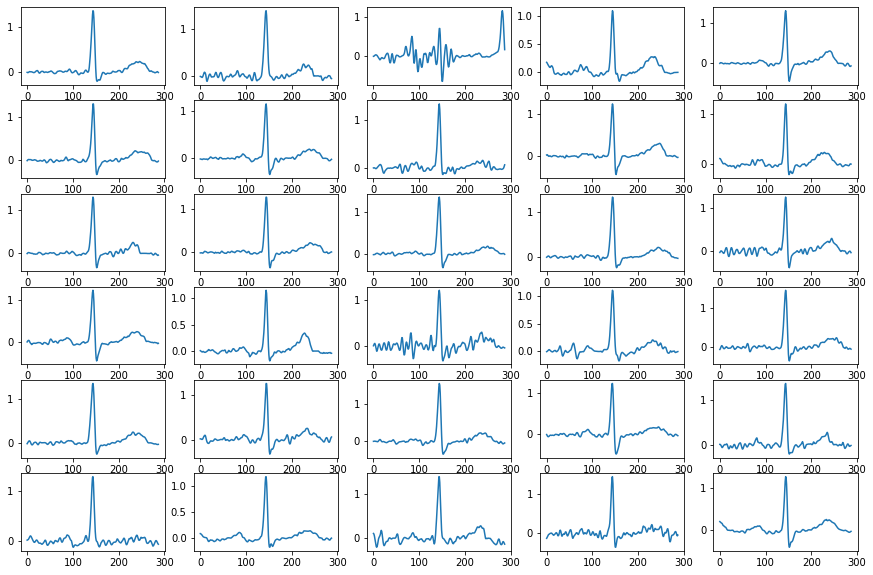

In [270]:
view_clustering(groups[0])

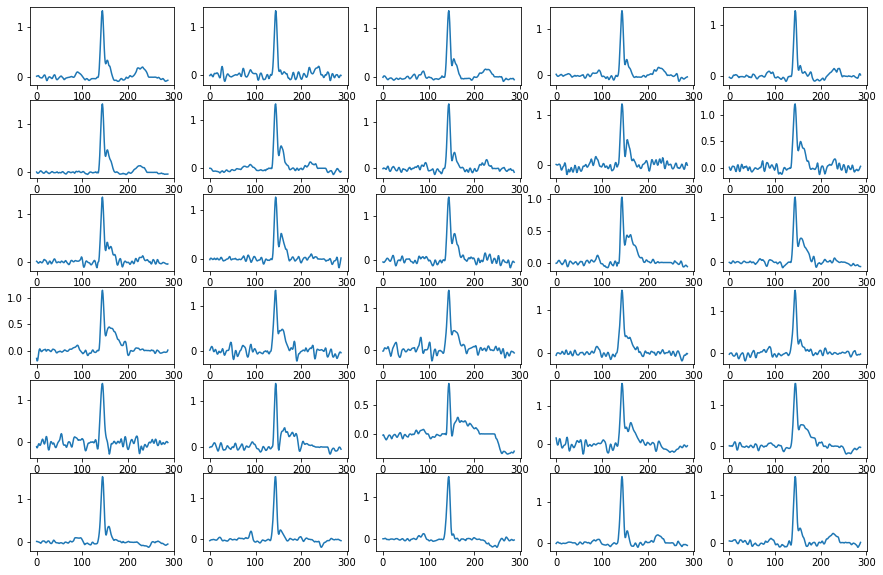

In [271]:
view_clustering(groups[1])

import umap

proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(op._aud_vq_vae._embedding.weight.data.cpu())
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

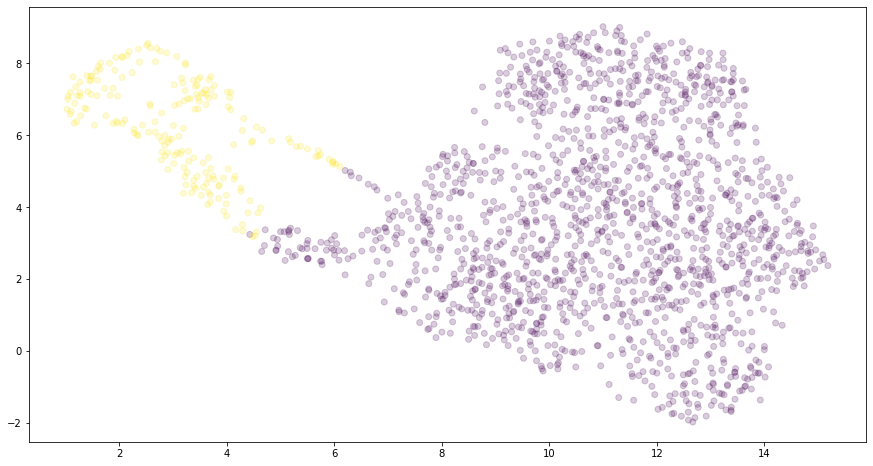

In [272]:
%matplotlib inline
fig = plt.figure(figsize=(15,8))
proj = umap.UMAP(n_neighbors=15, min_dist=0.5, random_state=42).fit_transform(heartbeats)

ax = fig.add_subplot(111)
ax.scatter(proj[:,0], proj[:,1],alpha=0.2, c=cluster_result)

Reclustering

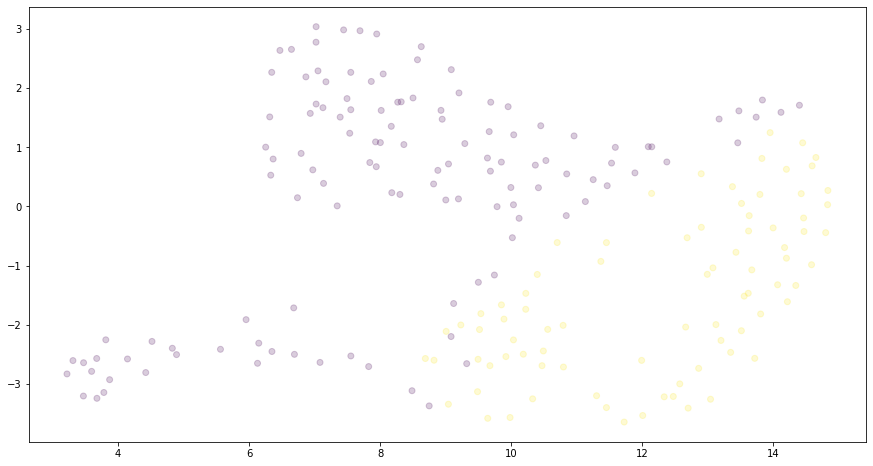

In [281]:
target_data = groups[1]
k = 2

model = KMeans(n_clusters = k, random_state = 100)

model.fit(target_data)

cluster_result = model.fit_predict(target_data)

%matplotlib inline
fig = plt.figure(figsize=(15,8))
proj2 = umap.UMAP(n_neighbors=15, min_dist=0.5, random_state=42).fit_transform(target_data)

ax = fig.add_subplot(111)
ax.scatter(proj2[:,0], proj2[:,1],alpha=0.2, c=cluster_result)

# Whole Data

In [219]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

import umap
from scipy import signal
from pandas import Series
import padasip as pa

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

# Data Extract From Physionet *.dat

input_path = "../ECG_DATASET/mitbih_stch/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
#     if l in ["00735","03665"]:
#         continue
    records_list.append(l)
records.close()
print(records_list)

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327']


In [220]:
def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], sampfrom=sampfrom, sampto = sampto)
    record_ann = wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto) # R Peak x_position
    record_ann_sym = wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto) # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)

    return record_sig, record_ann, record_ann_sym

# R peak Detection?
def BandpassECG(Fs,data):
    w1 = 0.5*2/Fs # 5hz cut-off (High-pass) and normalize / Nyquist Frequency : (2/Fs)
    w2 = 15*2/Fs # 15hz cut-off (low-pass) and normalize
    b, a = signal.butter(4, [w1,w2], "bandpass") # 5~15Hz를 Filtering하는 Butterworth filter
    
    ECG_BP = signal.filtfilt(b,a,data)
    
    return ECG_BP

def Differentiate(ecg):
    ecg_df = np.diff(ecg)
    ecg_sq = np.power(ecg_df,2)
    return np.insert(ecg_sq, 0, ecg_sq[0])

def movingAverage(ecg, N=20):
    window = np.ones((1,N)) / N
    ecg_ma = np.convolve(np.squeeze(ecg), np.squeeze(window))
    ecg_ma2 = np.convolve(np.squeeze(ecg_ma), np.squeeze(window))
    return ecg_ma2

def QRSPeaks(ecg, raw, Fs):
    """
    1. smooth한 데이터 값을 기준으로 Peak를 탐지함
    2. Smooth Peak를 기반으로 원 데이터의 final peak를 다시 탐지
    """
    peaks, _ = signal.find_peaks(ecg, height=np.mean(ecg), distance=round(Fs*0.2))
    
    final_peaks = []
    for pi in peaks:
        # pi : smooth peak
        start = pi - round(Fs/20)
        end = pi
        segment = raw[start:end]
        ei = signal.find_peaks(segment, height=np.mean(segment), distance=round(Fs*0.2))
        final_peaks.append(ei)
#         final_peaks.append(ei+pi-round(Fs/20)-1)
    print(final_peaks)
    return peaks

['300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327']

> 300 ~ 322 : ST Depression  
> 323 ~ 327 : ST Elevation

각 Subject에 대해 해야할 것 같음, subject마다 Amplitude가 달라서 전체 데이터를 넣고 분류하기엔..빡센듯
그리고 engzee segmenter를 쓰면 Threshold를 지정해줘야하는데, 이 Threshold에 따라 Beat분류가 되기때문...생각보다 높은 수치를 줘야함 안그럼 이상한 피크마저도 다 탐지함

우선은 내일 모든 기능을 함수화 해야할듯